<a href="https://colab.research.google.com/github/shanthan5327/ML_Models/blob/main/comment_toxicity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv('/content/train.csv')
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [3]:
from tensorflow.keras.layers import TextVectorization

In [4]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [5]:
Max_words = 160000

In [6]:
vectorizer = TextVectorization(max_tokens=Max_words,output_sequence_length=1800,output_mode='int')

In [7]:
vectorizer.adapt(X.values)

In [8]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [9]:
vectorized_text = vectorizer(X.values)
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [10]:
y.shape

(159571, 6)

In [11]:
vectorized_text.shape

TensorShape([159571, 1800])

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) #helps prevent bottlenecks

In [13]:
batch_x, batch_y = dataset.as_numpy_iterator().next()

In [14]:
batch_x.shape

(16, 1800)

In [15]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [17]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(Max_words+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [18]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          5120032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [20]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 [==============================] - 860s 122ms/step - loss: 0.0631 - val_loss: 0.0460
Epoch 2/5
6981/6981 [==============================] - 683s 98ms/step - loss: 0.0462 - val_loss: 0.0410
Epoch 3/5
6981/6981 [==============================] - 673s 96ms/step - loss: 0.0419 - val_loss: 0.0363
Epoch 4/5
6981/6981 [==============================] - 677s 97ms/step - loss: 0.0380 - val_loss: 0.0336
Epoch 5/5
6981/6981 [==============================] - 692s 99ms/step - loss: 0.0342 - val_loss: 0.0298


In [21]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

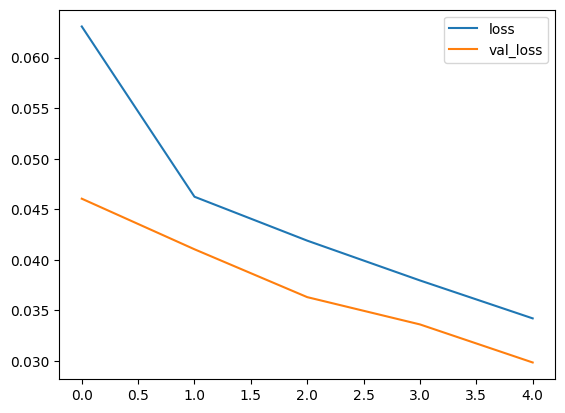

In [22]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [24]:
input_text = vectorizer('You freaking suck!')

In [25]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7158,  397, ...,    0,    0,    0])>

In [27]:
np.expand_dims(input_text,0)

array([[   7, 7158,  397, ...,    0,    0,    0]])

In [28]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 57ms/step


array([[0.99711704, 0.12944321, 0.9604311 , 0.00933362, 0.892663  ,
        0.05967536]], dtype=float32)

In [38]:
batch = test.as_numpy_iterator().next()

In [39]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [40]:
res = model.predict(batch_X) #this is basically passing multiple comments

1/1 [==============================] - 0s 68ms/step


In [41]:
res

array([[1.48791855e-06, 9.89061910e-17, 4.07149621e-08, 1.94133511e-11,
        2.51622856e-09, 3.46099732e-10],
       [9.87940431e-01, 8.11194256e-02, 9.10263419e-01, 8.00370891e-03,
        8.04218829e-01, 4.08187471e-02],
       [8.52221035e-07, 3.16614398e-17, 2.13412843e-08, 5.63801349e-12,
        1.08829590e-09, 1.41203021e-10],
       [3.22367596e-05, 2.78362267e-13, 1.46791876e-06, 5.22948707e-09,
        1.86518932e-07, 3.99894233e-08],
       [3.42995249e-04, 7.59213664e-11, 2.02492611e-05, 3.94191886e-07,
        5.20735648e-06, 1.45920922e-06],
       [1.52653578e-04, 6.65534121e-12, 6.67493259e-06, 9.68298366e-08,
        1.84195289e-06, 4.42298699e-07],
       [3.20481515e-04, 8.72397363e-11, 2.08942383e-05, 3.81570885e-07,
        4.72547845e-06, 1.41047121e-06],
       [3.91783897e-06, 1.01179155e-15, 1.23684131e-07, 1.24138672e-10,
        9.61611502e-09, 1.47566093e-09],
       [2.64277391e-04, 4.29179574e-11, 1.65412639e-05, 2.30683725e-07,
        3.20883305e-06, 

In [42]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [43]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [44]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 56ms/step


In [45]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8758620619773865, Recall:0.7972161769866943, Accuracy:0.498495489358902


In [46]:
!pip install gradio jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
  

In [47]:
import gradio as gr

In [48]:
model.save('toxicity.h5')

In [49]:
model = tf.keras.models.load_model('toxicity.h5')

In [50]:
input_str = vectorizer('I freaken hate you!')

In [51]:
res = model.predict(np.expand_dims(input_str,0))
res

1/1 [==============================] - 1s 1s/step


array([[0.76014256, 0.00180513, 0.04161203, 0.01231912, 0.2015571 ,
        0.04915133]], dtype=float32)

In [52]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [53]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [54]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

<ipython-input-54-f5d8ac15336b>:2: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
<ipython-input-54-f5d8ac15336b>:2: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
<ipython-input-54-f5d8ac15336b>:2: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),


In [55]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://f95918a46878129a3d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
